In [21]:
%pylab inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import datetime as dt

Populating the interactive namespace from numpy and matplotlib


In [22]:
import yatsm
from yatsm.io import read_pixel_timeseries
from yatsm.utils import csvfile_to_dataframe, get_image_IDs
from yatsm.config_parser import convert_config, parse_config_file
from yatsm.config_parser import convert_config, parse_config_file
import yatsm._cyprep as cyprep

In [24]:
## SPECIFY CONFIG FILE
config_file = '/projectnb/landsat/projects/Massachusetts/p012r031/p012r031_config.yaml'

# Read in and parse config file
cfg = parse_config_file(config_file)

In [4]:
# Get files list
df = csvfile_to_dataframe(cfg['dataset']['input_file'], \
                          date_format=cfg['dataset']['date_format'])

In [5]:
# Get dates
df['image_ID'] = get_image_IDs(df['filename']) 
df['x'] = df['date'] 
dates = df['date'].values

In [6]:
# SPECIFY PIXEL TO RUN
py = 4538 # row
px = 4622 # column

In [7]:
# Configure model
model = cfg['YATSM']['algorithm_cls']
algo_cfg = cfg[cfg['YATSM']['algorithm']]
yatsm = model(estimator=cfg['YATSM']['estimator'], \
                  **algo_cfg.get('init', {}))
yatsm.px = px
yatsm.py = py

In [ ]:
# Setup algorithm and create design matrix (if needed)
#X = yatsm.setup(df, **cfg)
#design_info = getattr(X, 'design_info', None)

In [8]:
# Read in time series as numpy array
Y = read_pixel_timeseries(df['filename'], px, py)

In [9]:
# Mask based on physical constraints and Fmask 
valid = cyprep.get_valid_mask( \
            Y, \
            cfg['dataset']['min_values'], \
            cfg['dataset']['max_values']).astype(bool)

# Apply mask band
idx_mask = cfg['dataset']['mask_band'] - 1
valid *= np.in1d(Y.take(idx_mask, axis=0), \
                         cfg['dataset']['mask_values'], \
                         invert=True).astype(np.bool)

Y = np.delete(Y, idx_mask, axis=0)[:, valid]
#X = X[valid, :]
dates = dates[valid]

In [10]:
dt_dates = np.array([dt.datetime.fromordinal(d) for d in dates])

In [11]:
# Plot time series - visual check
plt.plot(dt_dates, Y[7, :],'ko')
plt.show()

In [12]:
# Read np array into pandas dataframe - exclude Fmask result
Y_df = pd.DataFrame(Y[0:10])

In [16]:
# Transpose time series dataframe for correlation analysis
Y_t = Y_df.transpose()
Y_t.columns = ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', \
                        'Thermal', 'Brightness', 'Greenness', 'Wetness'] 

In [17]:
# Calculate pearson correlation matrix
corr_df = Y_t.corr(method='pearson')
corr_df

,Blue,Green,Red,NIR,SWIR1,SWIR2,Thermal,Brightness,Greenness,Wetness
Blue,1.000000,0.975799,0.955879,0.936266,0.914087,0.916465,0.196379,0.954145,0.099785,-0.878688
Green,0.975799,1.000000,0.987799,0.960491,0.937813,0.937874,0.226050,0.977501,0.112700,-0.899280
Red,0.955879,0.987799,1.000000,0.974316,0.958465,0.952386,0.209376,0.988096,0.154416,-0.921435
NIR,0.936266,0.960491,0.974316,1.000000,0.973327,0.965795,0.236916,0.991375,0.353700,-0.944942
SWIR1,0.914087,0.937813,0.958465,0.973327,1.000000,0.990001,0.210523,0.986470,0.254123,-0.990470
SWIR2,0.916465,0.937874,0.952386,0.965795,0.990001,1.000000,0.210741,0.982781,0.216499,-0.992159
Thermal,0.196379,0.226050,0.209376,0.236916,0.210523,0.210741,1.000000,0.222201,0.167571,-0.201025
Brightness,0.954145,0.977501,0.988096,0.991375,0.986470,0.982781,0.222201,1.000000,0.236355,-0.963277
Greenness,0.099785,0.112700,0.154416,0.353700,0.254123,0.216499,0.167571,0.236355,1.000000,-0.240562
Wetness,-0.878688,-0.899280,-0.921435,-0.944942,-0.990470,-0.992159,-0.201025,-0.963277,-0.240562,1.000000


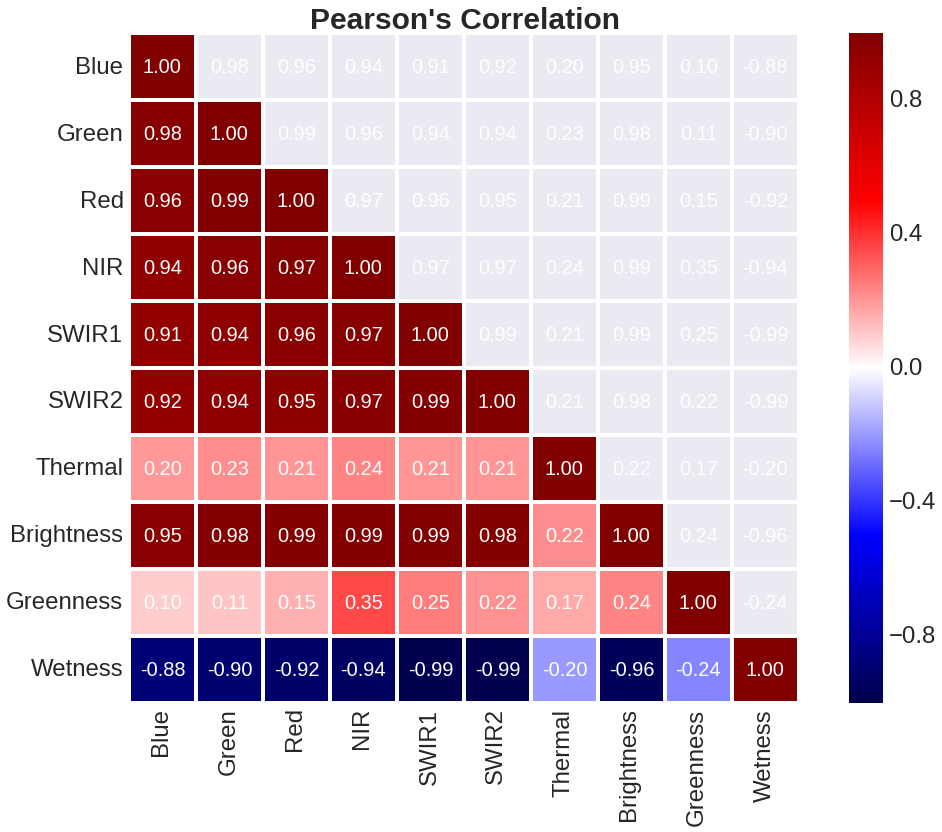

In [27]:
# Create a mask to display only the lower triangle of the matrix (since it's mirrored around its 
# top-left to bottom-right diagonal).
mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask, 1)] = True

# Create the heatmap using seaborn library. 
# List if colormaps (parameter 'cmap') is available here: http://matplotlib.org/examples/color/colormaps_reference.html

plt.figure(figsize=(18,12),facecolor='w', edgecolor='k')
seaborn.heatmap(corr_df, cmap='seismic', vmax=1.0, vmin=-1.0, linewidths=2.5, mask = mask, square=True)
seaborn.heatmap(corr_df, cmap='gist_rainbow', cbar=False, annot=True, fmt='0.2f', annot_kws={"size": 20}, alpha=0.0, square=True)

# Show the plot we reorient the labels for each column and row to make them easier to read.
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=24)

plt.yticks(rotation=0, size=24) 
plt.xticks(rotation=90, size=24)
plt.title("Pearson's Correlation", size=30, weight='bold')
plt.show()